<script>
        var code_show=true; //true -> hide code at first
    
        function code_toggle() {
            $('div.prompt').hide(); // always hide prompt
            $('div[style*=\"border-style: dashed"\]').hide(); // hide extra comments, usually log from treasuredata
            $('div.output_stderr').parent().hide();
    
            if (code_show){
                $('div.input').hide();
            } else {
                $('div.input').show();
            }
            code_show = !code_show
        }
        $( document ).ready(code_toggle);
    </script>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

plt.style.use("bmh")

# Introduction

## Background

On weekdays, I commute using either train or TransJakarta. Since those are public transportations, we can't expect the vehicle has enough space for all passengers (yes, I don't even mention *comfortable*). Thus, sometimes I have to wait for the next train or bus, wishing that there is more space to get in. The question is, will the train/bus be spacious enough so that I could get in?

## Research Questions

How likely will I get in a bus after waiting for certain minutes?

# Assumptions and Known Limitations

- This analysis focuses on bus, not train, assuming that I don't have any other commuting options if I am already waiting at the train station. Meanwhile, if the bus doesn't arrive, I can use ride-hailing service.
- The survival analysis is based on Kaplan-Meier estimator

# Data Preparation

The dataset contains 1,000 observations which simulate bus waiting time, which ranges from 1 to 45 minutes. `observed` attribute describes whether I get in the bus or not after waiting for `wait_time` minutes.

In [3]:
from random import randint
import datetime

n = 1000 # number of observations
start_date = datetime.datetime(2018,1,1,8,0,0)
wait_time = []
end_date = []

for i in range(n):
    date = start_date + datetime.timedelta(minutes=randint(1,45))
    wait_time.append((date.hour-8)*60 + date.minute)
    end_date.append(date.strftime(format='%H:%M'))

In [4]:
df = pd.DataFrame(
    data = {
        'start_time': np.repeat(start_date.strftime(format='%H:%M'), n),
        'end_time': end_date,
        'wait_time': np.array(wait_time).T,
        'observed': np.random.binomial(n=1, p=.5, size=n)
    }
)

In [5]:
print("Dataset preview:")
df.tail(5)

Dataset preview:


,start_time,end_time,wait_time,observed
995,08:00,08:20,20,1
996,08:00,08:15,15,1
997,08:00,08:42,42,1
998,08:00,08:11,11,1
999,08:00,08:18,18,0


# Analysis

We use Kaplan-Meier estimator to calculate probability of getting a bus after waiting for *x* minutes. Wait, how does it work?

We aggregate the dataset based on the time attribute (`wait_time`), then we calculate number of `observed` events (get in bus). There are cases when we haven't observed the final result due to **censoring**: at the time of data collection, the `observed` event doesn't occur yet and we lost track of the final outcome. For example, I haven't got in the bus after waiting for 30 minutes, and we don't know whether I continue waiting until I get in the bus or decide to use other means of transportation.

In [6]:
# from lifelines.plotting import plot_lifetimes

# plt.title("Observed vs censored events")
# plot_lifetimes(df['wait_time'].head(10), df['observed'].head(10));

We construct survival table from the aggregated data, then we use survival function $S(t)$ to calculate the survival probability.

<br/>
<center> $S(t) = Pr(T > t)$ </center>

> In plain English: the survival function defines the probability the death event has not occured yet at time $t$, or equivalently, the probability of surviving past time $t$. - [Lifelines Documentation](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html#survival-function)

The `observed` event on our case is "getting in the bus", then the survival function calculates probability of **not** getting in the bus at time $t$; it is displayed on `KM_estimate` field below. To make it more intuitive, we can use $1 - \text{KM_estimate}$ to resemble probability of getting in the bus.

In [7]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(durations=df['wait_time'], 
        event_observed=df['observed']);

In [8]:
from lifelines.utils import survival_table_from_events

table = survival_table_from_events(df['wait_time'], df['observed'])
table = table.merge(
    kmf.survival_function_,
    how='left',
    left_index=True,
    right_index=True
)
print("Survival table")
print("==============\n")
print(table.head(10))

table['prob_get_in_bus'] = 1-table['KM_estimate'].values

Survival table

          removed  observed  censored  entrance  at_risk  KM_estimate
event_at                                                             
0.0             0         0         0      1000     1000     1.000000
1.0            33        23        10         0     1000     0.977000
2.0            22        10        12         0      967     0.966897
3.0            26        13        13         0      945     0.953595
4.0            19         7        12         0      919     0.946332
5.0            19        10         9         0      900     0.935817
6.0            22         9        13         0      881     0.926257
7.0            21         9        12         0      859     0.916552
8.0            20        11         9         0      838     0.904521
9.0            18         9         9         0      818     0.894569


Median: 34 minutes


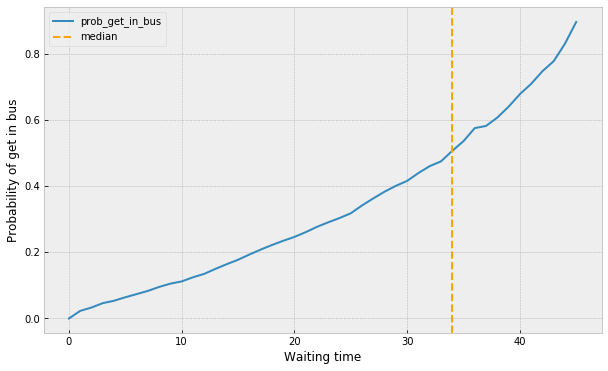

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
table['prob_get_in_bus'].plot(ax=ax)
ax.axvline(kmf.median_, linestyle='--', c='orange', label='median')

plt.xlabel("Waiting time")
plt.ylabel("Probability of get in bus")
plt.legend();

print('Median: {:.0f} minutes'.format(kmf.median_))

Based on the survival probability, I am more likely to get in the bus after waiting for 34 minutes. It surely is crowded at the city, eh?

Given this kind of analysis, we could suggest to add more buses so that passengers don't have to wait for such a long time.

# References

- [Lifelines documentation](https://lifelines.readthedocs.io/en/latest/Quickstart.html#kaplan-meier-and-nelson-aalen), accessed at November 15, 2018.

In [32]:
# # Extras: hazard function
# # to estimate probability of observing death event
# from lifelines import NelsonAalenFitter
# naf = NelsonAalenFitter()

# naf.fit(df['wait_time'], df['observed']);
# naf.plot(title="Hazard Function using Nelson Aalen Fitter");

In [33]:
# # Extras: weibull fitter
# from lifelines import WeibullFitter

# wf = WeibullFitter()
# wf.fit(df['wait_time'], df['observed'])
# # print(wf.lambda_, wf.rho_)
# # wf.print_summary()

# wf.cumulative_hazard_.plot(title="Hazard Function using Weibull Estimate");